In [63]:
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
import pickle
import shap
import datetime as dt

In [2]:
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

In [34]:
target = 'DTS'
drop_cols = ['Zone_Tertiary', 'Zone_Paleocene', 'Zone_Chalk', 'Zone_Jurassic', 'Depth']

In [35]:
# Import the datasets we exported from the data prep notebook. Drop the 'dateRep' column.
train_X = pd.read_csv("./data/train/train_x_Paleocene_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)
train_y = pd.read_csv("./data/train/train_y_Paleocene_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)

test_x = pd.read_csv("./data/test/test_x_Paleocene_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)
test_y = pd.read_csv("./data/test/test_y_Paleocene_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)

In [ ]:
train

In [36]:
#train_X.drop(drop_cols, inplace=True, axis=1)
#test_x.drop(drop_cols, inplace=True, axis=1)

In [39]:
params = {'max_depth':[5, 10, 15],
          'eta': [0.1, 0.2, 0.3, 0.5],
          'n_estimators': [50, 100, 200],
          'min_child_weight':[1, 2, 3, 5],
          'gamma': [1, 2, 3, 5]}

In [40]:
xgbr = XGBRegressor(objective="reg:squarederror",
                    eval_metric='mae',
                    num_round=30,
                    silent = 0)

In [41]:
clf = GridSearchCV(estimator=xgbr,
                     param_grid=params,
                     scoring='neg_mean_absolute_error',
                     cv=2,
                     verbose=1,
                     n_jobs=-1)

In [42]:
# Train the model. Can take > 10 minutes.
clf.fit(train_X.values, train_y.values)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 13.3min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, eval_metric='mae',
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nthread=None, num_round=30,
                                    objective='reg:squarede...
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=0,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.1, 0.2, 0.3, 0.5], 'gamma': [1

In [43]:
# Export the computed model for quick import again later.
if os.path.exists("./model") is False:
    os.mkdir("./model")
pickle.dump(clf, open("./model/XGBoost_" + str(dt.datetime.today().strftime('%Y-%m-%d'))+ ".pkl", "wb"))

In [9]:
# This code is to import the ready made model
#clf = pickle.load(open("./model/XGBoost_2021-04-23.pkl", "rb"))

In [44]:
best_model = clf.best_estimator_

In [45]:
rand_X = train_X.sample(frac=0.006, random_state=42)
len(rand_X)

210

In [46]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(best_model, rand_X)
shap_values = explainer.shap_values(rand_X)

In [47]:
#del train_X['deaths_pred']
names= train_X.columns.to_list()
#names = 
names

['GR', 'DT', 'DRES', 'DEN', 'COND', 'CAL']

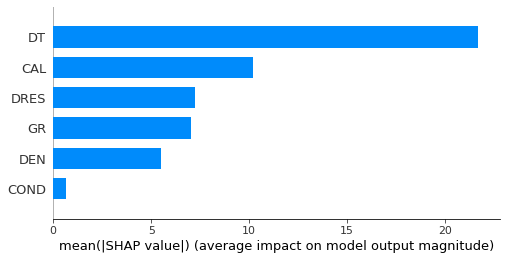

In [48]:
shap.summary_plot(shap_values, train_X, names, plot_type="bar", show=False)
#plt.savefig('SHAP_Feature_Score_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

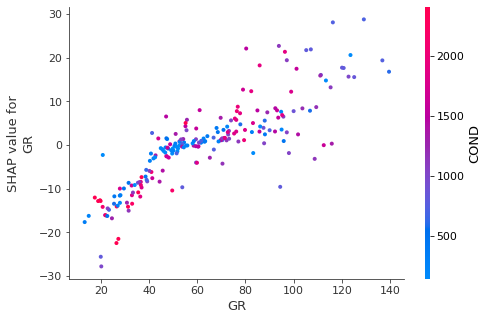

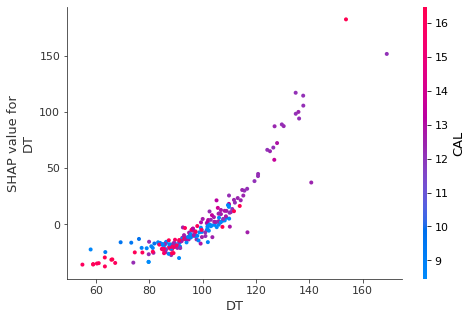

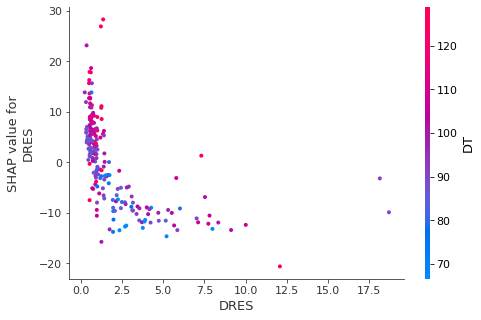

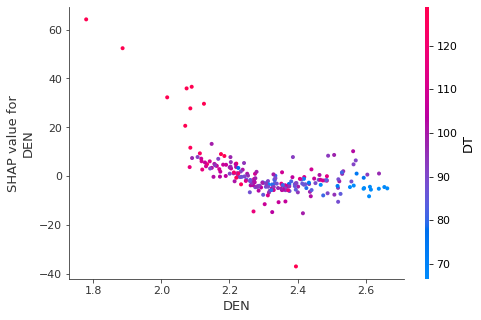

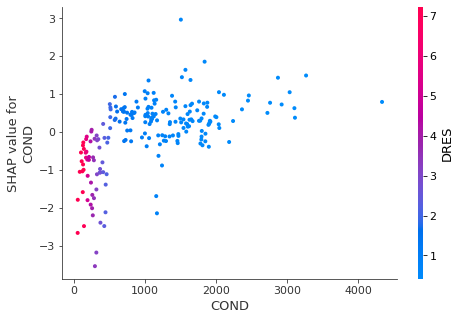

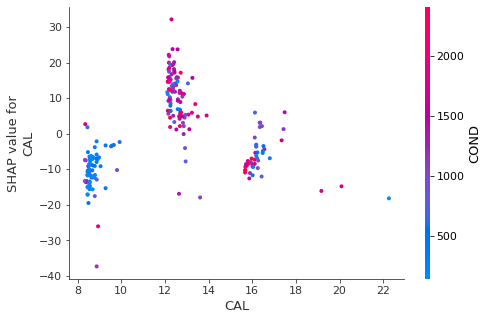

In [50]:
for i in names:
    # SHAP asigned value for an input parameter vs its value. Coloured by a random input feature
    shap.dependence_plot(i, shap_values, rand_X)

In [51]:
shap.force_plot(explainer.expected_value, shap_values, train_X)

In [52]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value, shap_values[0,:], train_X.iloc[0,:])

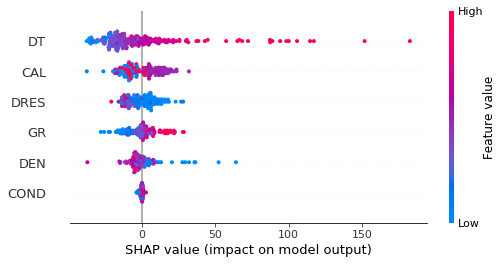

In [54]:
shap.summary_plot(shap_values, rand_X)

In [103]:
# Concatenate together the test x and y dataframes
df = pd.concat([test_x, test_y], axis=1)
# Merge the train X and y dataframes
df1 = train_X.merge(train_y, left_index=True, right_index=True)

In [59]:
df.head(3)

,GR,DT,DRES,DEN,COND,CAL,DTS
78708,90.5117,102.8257,1.1186,2.3977,893.9746,6.1016,187.2424
14853,41.7731,82.6216,0.9587,2.3488,1043.0792,12.0178,143.2224
23149,82.6965,83.6770,1.0391,2.3957,962.3712,12.6323,156.5547


In [105]:
# Predicting the daily deaths for each country using our model
y_pred = clf.predict(test_x.values) # model.predict(df_x[train_X.columns].values)
df["dts_pred"] = y_pred
# Computing the model error
df["model_error"] = df[target] - df["dts_pred"]

# Predicting the daily deaths for each country using our model
ytrain_pred = clf.predict(train_X.values) # model.predict(df_x[train_X.columns].values)
df1["dts_pred"] = ytrain_pred
# Computing the model error
df1["model_error"] = df1[target] - df1["dts_pred"]

In [106]:
print(f"XGBoost MAE score: {np.round(mean_absolute_error(df[target], df.dts_pred))}")
print(f"XGBoost RMSE score: {np.round(mean_squared_error(df[target], df.dts_pred, squared=False))}")
print(f"XGBoost R2 score: {np.round(r2_score(df[target], df.dts_pred), 4)}")

XGBoost MAE score: 28.0
XGBoost RMSE score: 43.0
XGBoost R2 score: 0.5735


Text(0, 0.5, 'predicted Deaths')

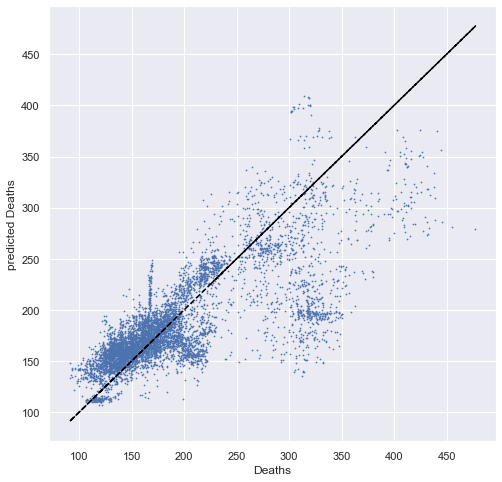

In [107]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target], df.dts_pred, s=0.5)
plt.plot(df[target], df[target], color="black", linestyle="--")
plt.xlabel("Deaths")
plt.ylabel("predicted Deaths")
#plt.show()

In [78]:
# Append df and df1 so that we now have the complete dataframe again
df = df.append(df1)
# Import in the covid19_df from the data prep stage for a full comparison to the predictions
df_global = pd.read_csv('.\Data\Quads_20_21_22_clean.csv', index_col=0)
# Merge the df_global dataframe with the predicted deaths and model error columns we created
df_global = df_global.merge(df[['dts_pred', 'model_error']], left_index=True, right_index=True)
# Calculate the cumulative error in the model for each country using a 'groupby'
# Recreate the top_count list using the line below
top_count = ['21-8-4', '21-1a-19','20-7b-5', '20-5c-11','21-24-6', '22-14b-8','22-14b-5', '22-30a-14Y','21-1a-19y']

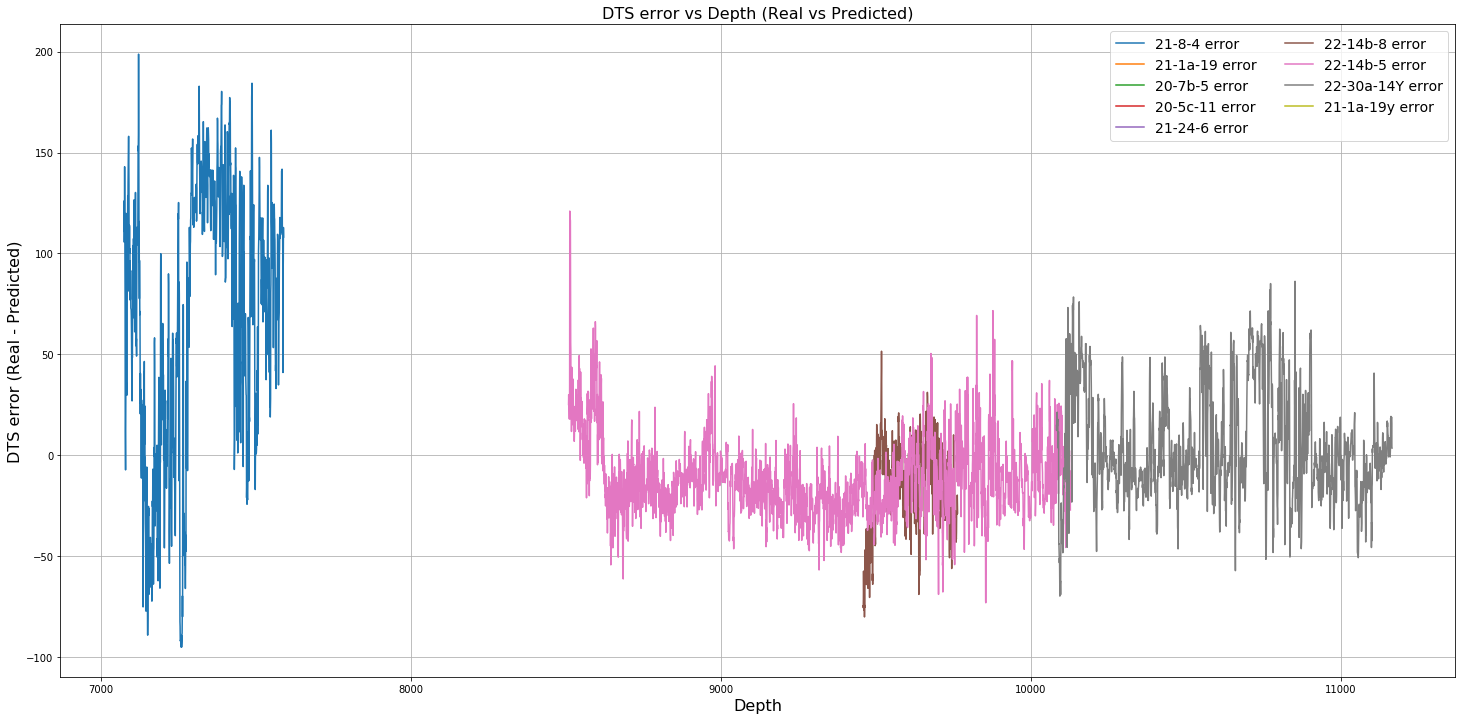

In [84]:
#plt.style.use('classic')
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for well in top_count:
    plt.plot(df_global[df_global["Wellname"] == well]["Depth"],
             df_global[df_global["Wellname"] == well]['model_error'], label=f"{well} error")
plt.title('DTS error vs Depth (Real vs Predicted)')
plt.xlabel('Depth')
plt.ylabel('DTS error (Real - Predicted)')
plt.grid()
plt.legend(ncol=2)
plt.show()

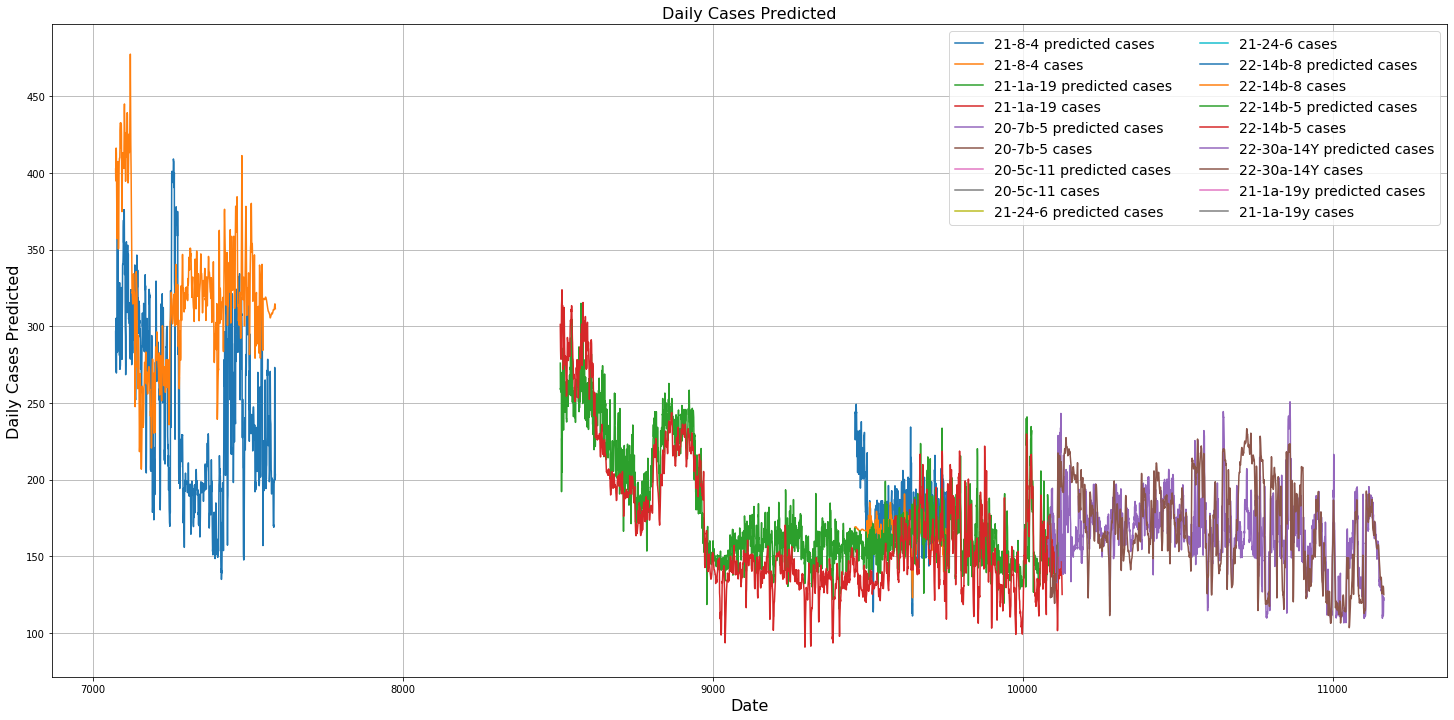

In [83]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for well in top_count:
    plt.plot(df_global[df_global["Wellname"] == well]["Depth"],
             df_global[df_global["Wellname"] == well]['dts_pred'], label=f"{well} predicted cases")
    plt.plot(df_global[df_global["Wellname"] == well]["Depth"],
         df_global[df_global["Wellname"] == well][target], label=f"{well} cases")
plt.title('Daily Cases Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Cases Predicted')
plt.grid()
plt.legend(ncol=2)
plt.show()

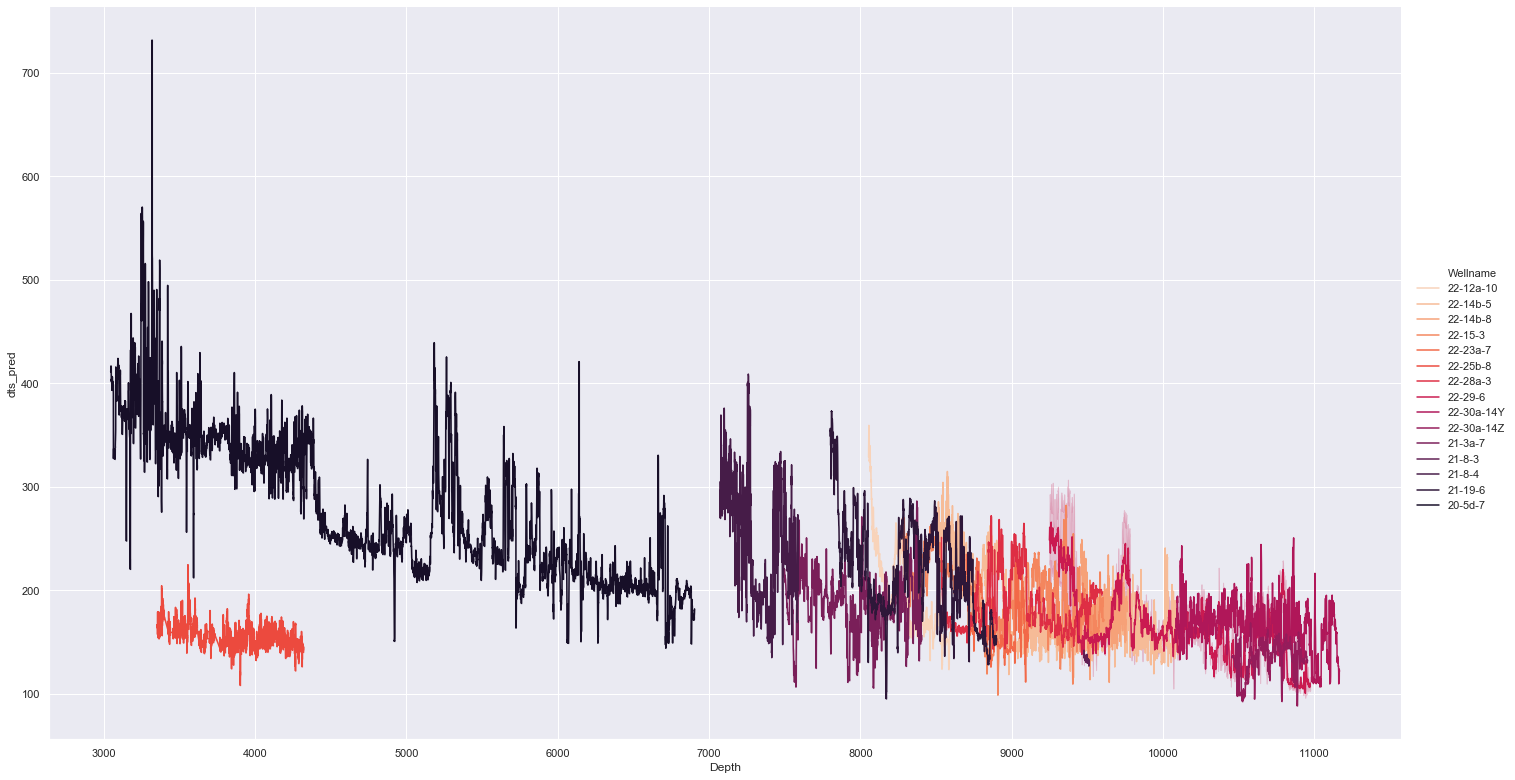

In [87]:
# Define a palette to ensure that colors will be
# shared across the facets
#sns.set_context(font_scale=101.5)
palette = dict(zip(df_global.Wellname.unique(),
                   sns.color_palette("rocket_r", len(df_global.Wellname.unique()))))
sns.set(rc={'figure.figsize':(12,9)}) #,font_scale=1.8)
# Plot the lines
g = sns.relplot(x="Depth", y="dts_pred",
            hue="Wellname", palette=palette,
            height=11, aspect=1.8, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=df_global)
#plt.savefig('residual_deaths_20_countries_XGB_dpi300.jpeg', dpi=300)

In [102]:
print(f"XGBoost MAE score: {np.round(mean_absolute_error(df_global['DTS'], df_global['dts_pred']))}")
print(f"XGBoost RMSE score: {np.round(mean_squared_error(df_global['DTS'], df_global['dts_pred'], squared=False))}")
print(f"XGBoost R2 score: {np.round(r2_score(df_global['DTS'], df_global['dts_pred']), 4)}")

XGBoost MAE score: 5.0
XGBoost RMSE score: 13.0
XGBoost R2 score: 0.9565


In [33]:
if os.path.exists(os.path.join(data_folder, "model_predictions")) is False:
    os.mkdir(os.path.join(data_folder, "model_predictions"))
df_global.to_csv(os.path.join(data_folder, "model_predictions", "xgb_predictions.csv"))

Text(0.5, 0, 'Prediction error')

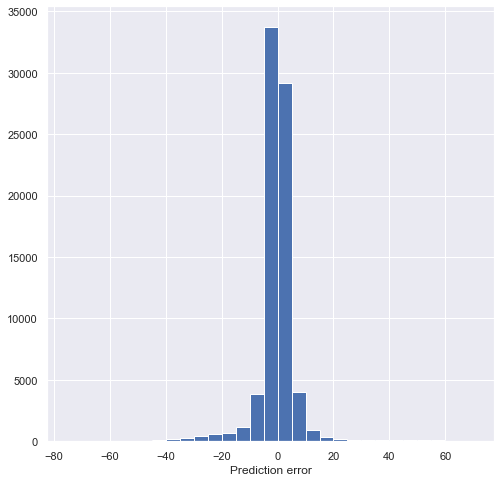

In [95]:
#plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.hist(df["model_error"], bins=np.arange(-75, 75, 5))
plt.xlabel("Prediction error")
#plt.show()

Text(0, 0.5, 'predicted Deaths')

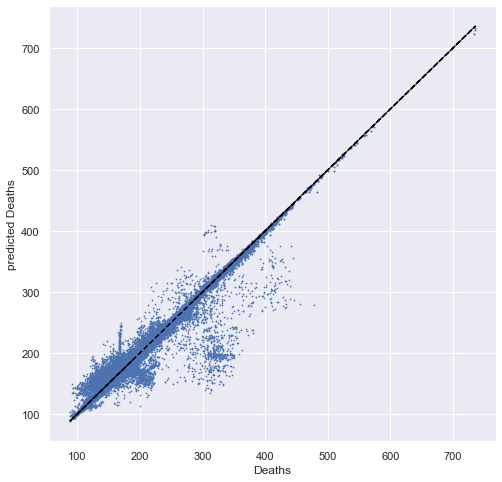

In [98]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target], df.dts_pred, s=0.5)
plt.plot(df[target], df[target], color="black", linestyle="--")
plt.xlabel("Deaths")
plt.ylabel("predicted Deaths")
#plt.show()